репродукция на показаното в лекцията:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from IPython.display import display

#%matplotlib notebook


import sklearn
import matplotlib as mpl
import seaborn as sns

import re

%matplotlib inline

pd.options.display.max_rows = 10

In [2]:
# Dataset

train = pd.read_csv("data/spooky/train.zip", index_col=['id'])
test = pd.read_csv("data/spooky/test.zip", index_col=['id'])
sample_submission = pd.read_csv("data/spooky/sample_submission.zip", index_col=['id'])

print(train.shape, test.shape, sample_submission.shape)
print(set(train.columns) - set(test.columns))

(19579, 2) (8392, 1) (8392, 3)
{'author'}


In [3]:
train.head(5)

,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score

In [5]:
pipeline = Pipeline([
    ('features', CountVectorizer()),
    ('clf', LogisticRegression())
])

print('       score:', cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3))
print('neg_log_loss:', cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3, 
                      scoring='neg_log_loss'))

       score: [ 0.81449142  0.81673307  0.81348659]
neg_log_loss: [-0.47678328 -0.47558895 -0.47131481]


До тук имаме базов модел и оценка; Pipeline остава много неща скрити;

Ползването на cross_val_score изглежда зачиства резултатите (fit-a) от scope-а на pipeline:

In [6]:
from sklearn.exceptions import NotFittedError

count_vectorizer = pipeline.steps[0][1]
print(type(count_vectorizer))
try:
    count_vectorizer.vocabulary_
except (AttributeError, NotFittedError) as e:
    print(e)

<class 'sklearn.feature_extraction.text.CountVectorizer'>
'CountVectorizer' object has no attribute 'vocabulary_'


За да имаме поглед върху междинния формат на данните, ще fit-нем на ново count_vectorizer-а.

In [7]:
pipeline.fit(train.text, train.author)
count_vectorizer = pipeline.steps[0][1]
# count_vectorizer._validate_vocabulary()

In [8]:
list(count_vectorizer.vocabulary_.items())[:10]

[('this', 22175),
 ('process', 17139),
 ('however', 10784),
 ('afforded', 455),
 ('me', 13678),
 ('no', 14817),
 ('means', 13696),
 ('of', 15145),
 ('ascertaining', 1300),
 ('the', 22085)]

In [9]:
pd.set_option('display.float_format', '{:.2f}'.format)
slice_ = train.text[:10]
print('decision func:\n', pipeline.decision_function(slice_))
print('predict_proba:\n', np.round(pipeline.predict_proba(slice_),3))
print('predict :', pipeline.predict(slice_))
print('observed:', train.author.values[:10])

decision func:
 [[  6.88005027  -5.53085487  -8.55660704]
 [ -0.30598266  -0.0355784   -3.06925049]
 [  1.94575346  -1.73436774  -6.65837008]
 [ -6.24311246  -7.71766753   8.03335118]
 [ -1.08496043   0.50364988  -2.79939235]
 [ -4.47520353 -12.52733853   6.61040277]
 [  1.87293228  -1.83363116  -4.39112308]
 [  1.28128144  -2.76106269  -1.87615553]
 [  1.71256761  -4.20021945  -6.89789641]
 [ -1.54097308  -3.39287914   1.20978569]]
predict_proba:
 [[ 0.996  0.004  0.   ]
 [ 0.442  0.512  0.046]
 [ 0.853  0.146  0.001]
 [ 0.002  0.     0.998]
 [ 0.271  0.668  0.061]
 [ 0.011  0.     0.989]
 [ 0.852  0.136  0.012]
 [ 0.803  0.061  0.136]
 [ 0.982  0.017  0.001]
 [ 0.18   0.033  0.787]]
predict : ['EAP' 'HPL' 'EAP' 'MWS' 'HPL' 'MWS' 'EAP' 'EAP' 'EAP' 'MWS']
observed: ['EAP' 'HPL' 'EAP' 'MWS' 'HPL' 'MWS' 'EAP' 'EAP' 'EAP' 'MWS']


In [10]:
import itertools
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cross_val_predict != cross_val_score

In [11]:
from sklearn.model_selection import cross_val_predict

prediction = cross_val_predict(pipeline, train.text, train.author, cv=3, n_jobs=3)
prediction

array(['EAP', 'EAP', 'EAP', ..., 'EAP', 'EAP', 'HPL'], dtype=object)

Тази графика не дава информация за "увереността" на предположенията.

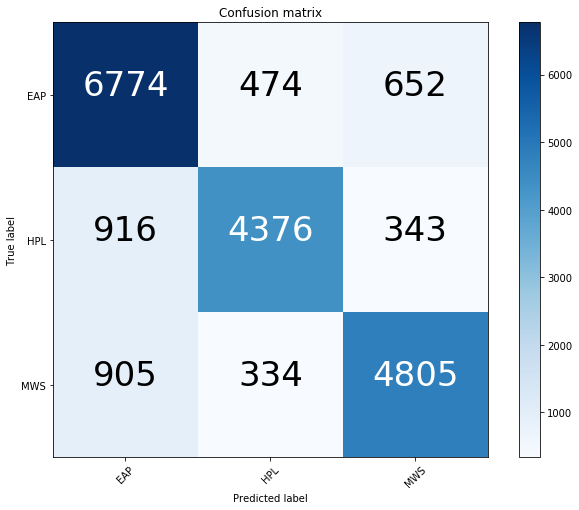

In [12]:
authors = pipeline.classes_
plot_confusion_matrix(train.author, prediction, classes=authors)

Следващите редове са изследване на опцията да представям log_loss в plot_confusion_matrix

In [13]:
authors

array(['EAP', 'HPL', 'MWS'], dtype=object)

In [14]:
single_ = train.text.iloc[0]
single_

'This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.'

In [15]:
pipeline.predict_proba([single_])

array([[  9.95873648e-01,   3.93471446e-03,   1.91637189e-04]])

In [16]:
single_probas = [ [z] for z in pipeline.predict_proba([single_])[0]]
single_probas

[[0.99587364835336278], [0.0039347144572666644], [0.00019163718937051345]]

In [17]:
[train.author.iloc[0]]

['EAP']

In [18]:
log_loss([1], [[0.5, 0.3333333, 0.0416666]], labels=[1, 0, 3])

0.96508088175787132

In [19]:
log_loss(y_true=[['EAP']], y_pred=[[0.99587364835336278,
                                 0.0039347144572666644,
                                 0.00019163718937051345]],
         labels=['EAP', 'HPL', 'MWS'])

0.004134888527801966

In [20]:
log_loss(y_true=[['EAP']], y_pred=pipeline.predict_proba([single_]),
         labels=authors)
#          labels=['EAP', 'HPL', 'MWS'])

0.004134888527801966

In [21]:
print(authors.tolist())
print(len(pipeline.predict_proba(train.text)))
print([list(train.author[:10])])
pipeline.predict_proba(train.text[:10]).tolist()

['EAP', 'HPL', 'MWS']
19579
[['EAP', 'HPL', 'EAP', 'MWS', 'HPL', 'MWS', 'EAP', 'EAP', 'EAP', 'MWS']]


[[0.9958736483533628, 0.003934714457266664, 0.00019163718937051345],
 [0.441952460968289, 0.5117847030623977, 0.04626283596931342],
 [0.8525653352362134, 0.14618590817393715, 0.001248756589849516],
 [0.0019360361367847896, 0.000443784897841265, 0.9976201789653739],
 [0.27063549295615785, 0.6679045517400033, 0.0614599553038388],
 [0.011149094075245636, 3.590525052634117e-06, 0.9888473153997018],
 [0.8524431480124934, 0.13552421197831618, 0.012032640009190439],
 [0.8027660284042524, 0.06099190805150025, 0.1362420635442474],
 [0.9817141786573361, 0.0171167035418542, 0.0011691178008096696],
 [0.18014563931187963, 0.03321040363574766, 0.7866439570523727]]

In [22]:
log_loss(y_true=list(train.author[:10]),
         y_pred=pipeline.predict_proba(train.text[:10]).tolist(),
         labels=authors.tolist())

0.18884749191598543

In [23]:
log_loss(y_true=list(train.author),
         y_pred=pipeline.predict_proba(train.text).tolist(),
         labels=authors.tolist())

0.20227348134133219

import relog_loss няма специфична стойност за всяка клетка от confusion_matrix, затова оставям версията от лекцията с `normalize=True`

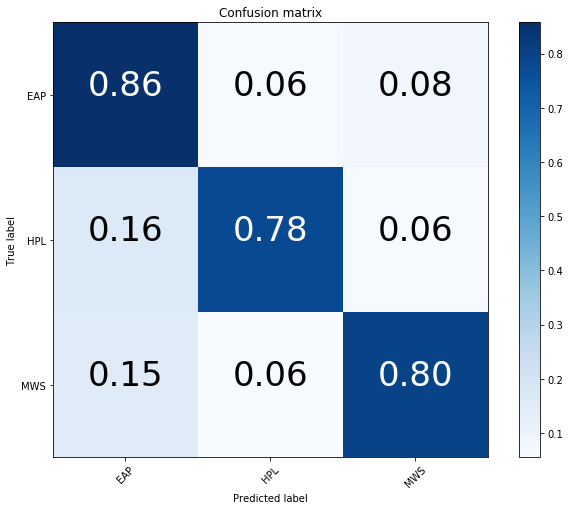

In [24]:
plot_confusion_matrix(train.author, prediction, classes=authors, normalize=True)

add som new features

In [25]:
explore = train.copy()

for name, char in {'question': '?', 'semicol': ';'}.items():
    explore[name] = explore.text.apply(lambda s: s.count(char))

explore[:10]

,text,author,question,semicol
id,,,,
id26305,"This process, however, afforded me no means of...",EAP,0,2
id17569,It never once occurred to me that the fumbling...,HPL,0,0
id11008,"In his left hand was a gold snuff box, from wh...",EAP,0,0
id27763,How lovely is spring As we looked from Windsor...,MWS,0,0
id12958,"Finding nothing else, not even gold, the Super...",HPL,0,1
id22965,"A youth passed in solitude, my best years spen...",MWS,0,0
id09674,"The astronomer, perhaps, at this point, took r...",EAP,0,1
id13515,The surcingle hung in ribands from my body.,EAP,0,0
id19322,I knew that you could not say to yourself 'ste...,EAP,0,1


In [26]:
print(explore.columns)
features_names = list(set(explore.columns) - {'text', 'author'})

Index(['text', 'author', 'question', 'semicol'], dtype='object')


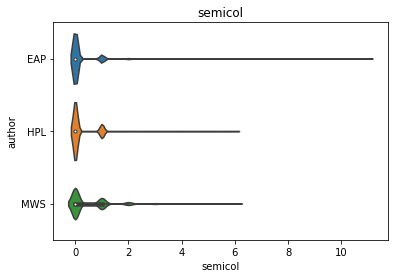

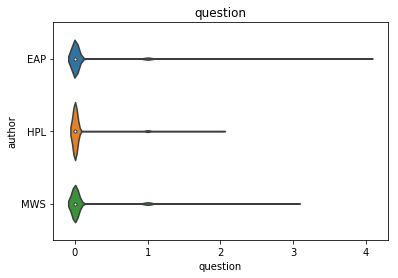

In [27]:
for feature in features_names:
    plt.figure()
    sns.violinplot(x=feature, y="author", data=explore)
    plt.title(feature);

In [28]:
from sklearn.svm import LinearSVC
cross_val_score(LinearSVC(), explore[features_names], explore.author, cv=3, n_jobs=1)

array([ 0.44623162,  0.44943304,  0.45011494])

In [29]:
explore[features_names].shape

(19579, 2)

In [30]:
explore.author.shape

(19579,)

In [31]:
try:
    print('       score:', cross_val_score(pipeline, explore[features_names], explore.author, cv=3, n_jobs=3))
#     print('neg_log_loss:', cross_val_score(pipeline, explore[features_names], explore.author, cv=3, n_jobs=3, 
#                           scoring='neg_log_loss'))
except ValueError as e:
    print(e)

JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/usr/lib/python3.6/runpy.py in _run_code(code=<code object <modul

In [32]:
for char in list('?!;'):
    transformed[char] = train.text.apply(lambda s: s.count(char))

NameError: name 'transformed' is not defined

In [ ]:
transformed

In [ ]:
# lr = LogisticRegression().fit(train[['text', '?', '!', ';']], train.author)